In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from empyrical import max_drawdown, alpha, beta
from sklearn.preprocessing import MinMaxScaler
from src.asset_selector import AssetSelector
from src.indicators import Indicators
from util import time_formatter
from src.predictor import Predictor
from sklearn.cluster import KMeans
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import pandas as pd
import numpy as np
import configparser
import requests
import json
import time
import sys
import os

config = configparser.ConfigParser()
try:
    config.read(os.path.relpath("config.ini"))
except FileExistsError as e:
    print("FileExistsError: {}".format(e))
    sys.exit(1)
alpaca_api = tradeapi.REST(
    base_url    = config["alpaca"]["APCA_API_BASE_URL"],
    key_id      = config["alpaca"]["APCA_API_KEY_ID"],
    secret_key  = config["alpaca"]["APCA_API_SECRET_KEY"],
    api_version = config["alpaca"]["VERSION"]
)
trading_account = alpaca_api.get_account()
sid = SentimentIntensityAnalyzer()

/home/ben/anaconda3/envs/alpaca_test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ben/anaconda3/envs/alpaca_test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ben/anaconda3/envs/alpaca_test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ben/anaconda3/envs/alpaca_test/lib

In [51]:
def get_sentiment(text):
    """Given a text block, return a sentiment score based.

    :param text:
    :return:
    """
    text_polarity   = sid.polarity_scores(text)
    print(text_polarity)

    if text_polarity["compound"] > 0.50:
        sentiment   = "positive"

    else:
        sentiment   = "negative"

    return sentiment

def get_losers():
    
    print('Losers'.center(45))
    print()
    print('Symbol'.ljust(10), 'Last'.ljust(11), 'Change'.ljust(11), 'Pct Loss')
    print("{:<30}".format('–' * 45))
    for symbol in range(len(alpaca_api.polygon.gainers_losers("losers"))):
        print(alpaca_api.polygon.gainers_losers("losers")[symbol].ticker.ljust(10),
              '$' + str(alpaca_api.polygon.gainers_losers("losers")[symbol].lastTrade['p']).ljust(10),
              '$' + str(alpaca_api.polygon.gainers_losers("losers")[symbol].todaysChange).ljust(10),
              str(alpaca_api.polygon.gainers_losers("losers")[symbol].todaysChangePerc)+'%')
def get_gainers():
    print('Gainers'.center(45))
    print()
    print('Symbol'.ljust(10), 'Last'.ljust(11), 'Change'.ljust(11), 'Pct Gain')
    print("{:<30}".format('–' * 45))
    for symbol in range(len(alpaca_api.polygon.gainers_losers())):
        print(alpaca_api.polygon.gainers_losers()[symbol].ticker.ljust(10),
              '$' + str(alpaca_api.polygon.gainers_losers()[symbol].lastTrade['p']).ljust(10),
              '$' + str(alpaca_api.polygon.gainers_losers()[symbol].todaysChange).ljust(10),
              str(alpaca_api.polygon.gainers_losers()[symbol].todaysChangePerc)+'%')
        
if __name__ == '__main__':
    
    get_gainers()
    print()
    get_losers()

                   Gainers                   

Symbol     Last        Change      Pct Gain
–––––––––––––––––––––––––––––––––––––––––––––

                    Losers                   

Symbol     Last        Change      Pct Loss
–––––––––––––––––––––––––––––––––––––––––––––


In [3]:
ticker = "FLGT"

In [4]:
selector    = AssetSelector(alpaca_api, edgar_token=None)
indicators  = Indicators(alpaca_api)

In [5]:
weeks = 13
backdate = time_formatter(time.time() - (604800 * weeks))

In [6]:
day_bars            = selector.get_barset(ticker, "day", backdate)
day_bars            = selector.extract_bar_data(day_bars, ticker)
minute_bars         = selector.get_barset(ticker, "minute", backdate)
minute_bars         = selector.extract_bar_data(minute_bars, ticker)
day_spy_bars        = selector.get_barset("SPY", "1D", backdate)
day_spy_bars        = selector.extract_bar_data(day_spy_bars, "SPY")
minute_spy_bars     = selector.get_barset("SPY", "minute", backdate)
minute_spy_bars     = selector.extract_bar_data(minute_spy_bars, "SPY")

In [7]:
# alpaca_api.polygon.historic_trades(ticker, '2019-10-10', limit=10)
# alpaca_api.polygon.news(ticker)
# alpaca_api.polygon.last_trade(ticker)
# alpaca_api.polygon.last_quote(ticker)
# alpaca_api.polygon.company(ticker)
# alpaca_api.polygon.dividends(ticker)

In [8]:
results = requests.post("https://api.stocktwits.com/api/2/streams/symbol/{}.json".format(ticker))
results = json.loads(results.text)

In [9]:
bodies = "\n".join([m["body"] for m in results["messages"]])
sentiment = get_sentiment(bodies)
sentiment

{'neg': 0.013, 'neu': 0.835, 'pos': 0.152, 'compound': 0.997}


'positive'

In [10]:
ticker_cluster = indicators.cluster_prep(ticker)

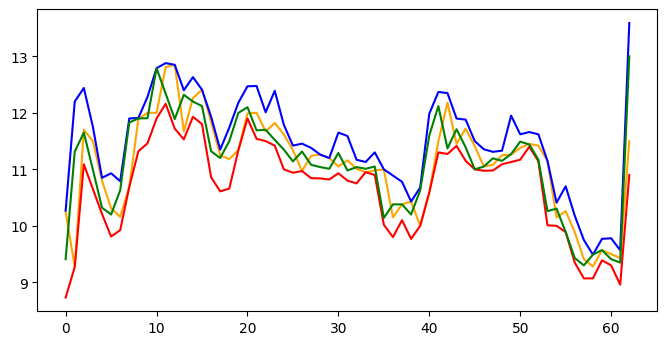

In [11]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["open"], color="orange")
plt.plot(ticker_cluster["high"], color="blue")
plt.plot(ticker_cluster["low"], color="red")
plt.plot(ticker_cluster["close"], color="green")

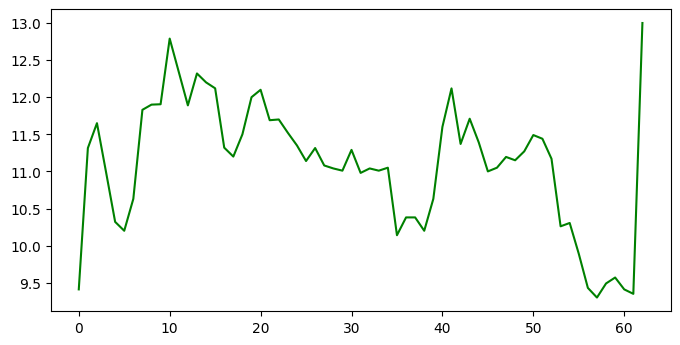

In [12]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["close"], color="green")

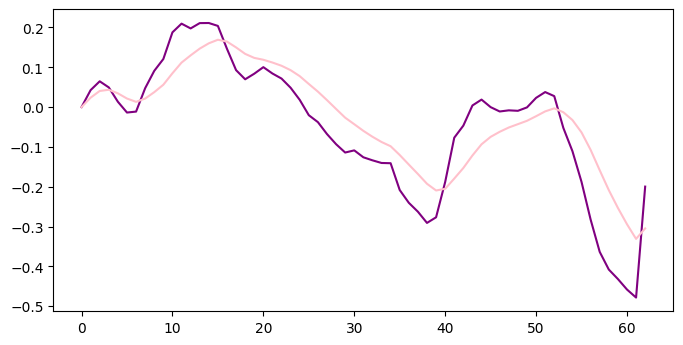

In [13]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["macd"], color="purple")
plt.plot(ticker_cluster["signal"], color="pink")

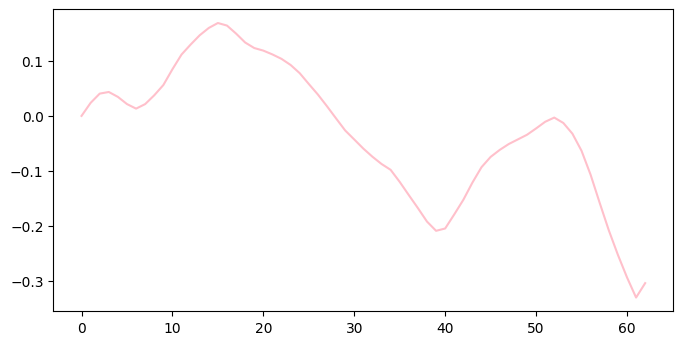

In [14]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["signal"], color="pink")

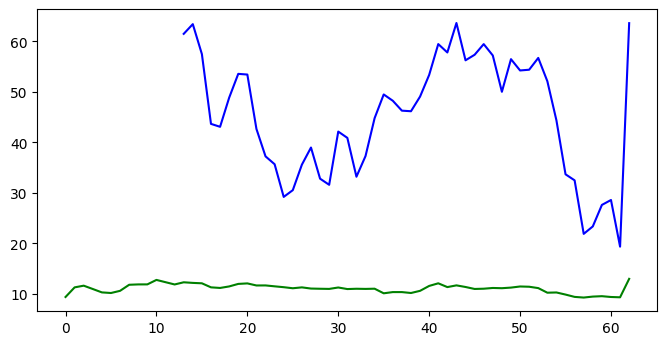

In [15]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["close"], color="green")
plt.plot(ticker_cluster["mfi"], color="blue")

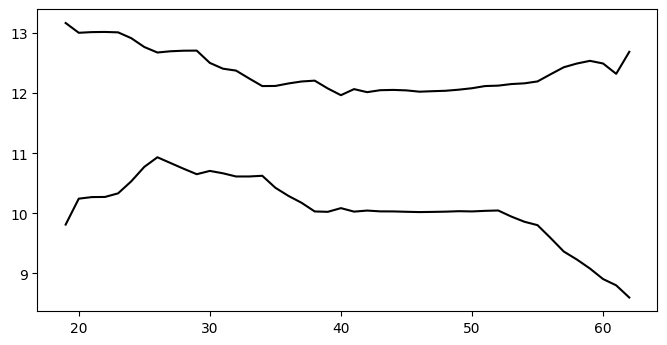

In [16]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["bb_up"], color="black")
plt.plot(ticker_cluster["bb_low"], color="black")

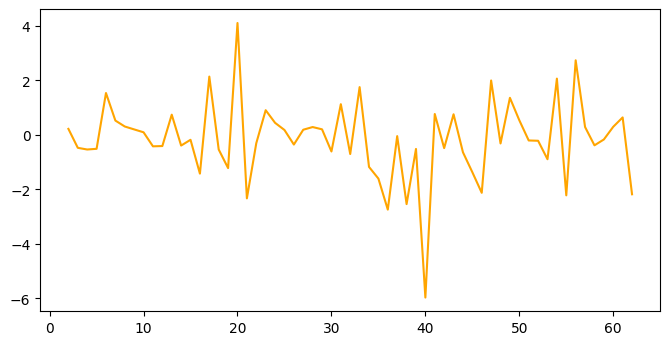

In [17]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["vzo"].pct_change(), color="orange")

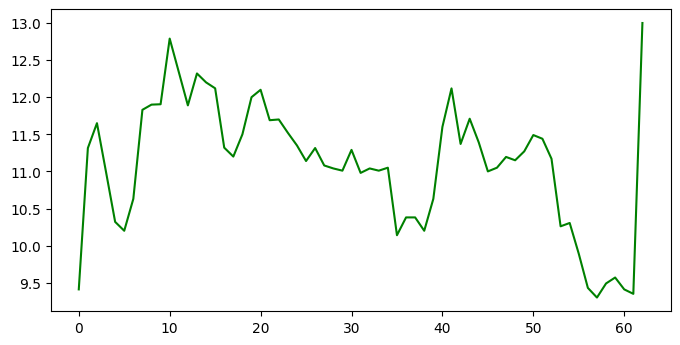

In [18]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["close"], color="green")

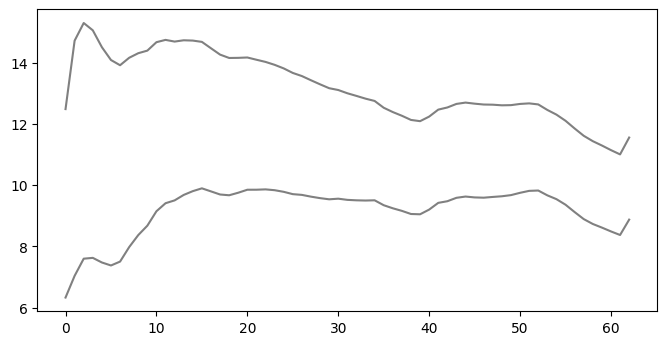

In [19]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["apz_u"], color="grey")
plt.plot(ticker_cluster["apz_l"], color="grey")

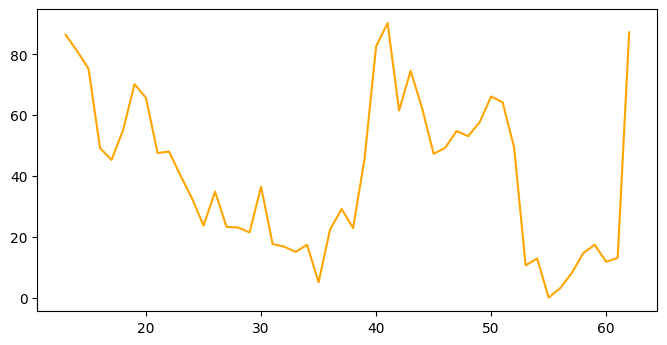

In [20]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["stoch"], color="orange")

In [21]:
# plt.plot(ticker_cluster["adx"], color="green")

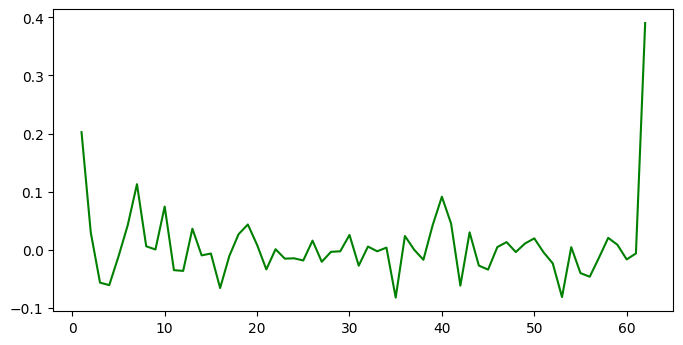

In [22]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["close"].pct_change(), color="green")

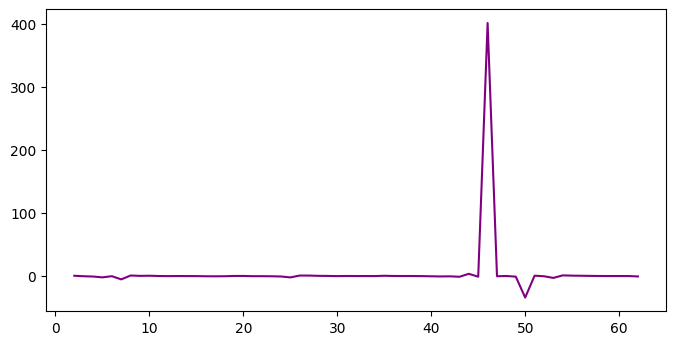

In [23]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["macd"].pct_change(), color="purple")

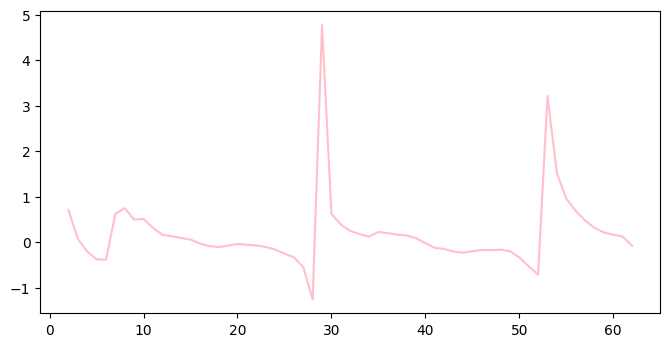

In [24]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["signal"].pct_change(), color="pink")

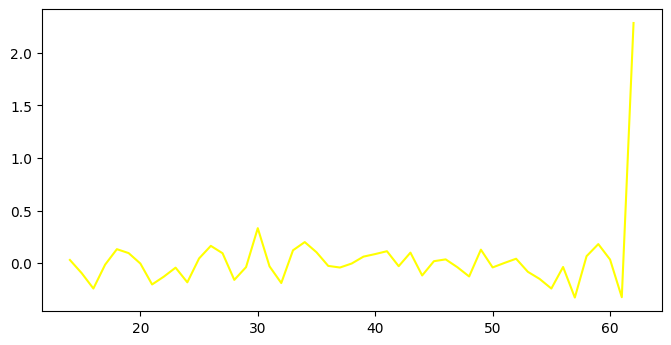

In [25]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["mfi"].pct_change(), color="yellow")

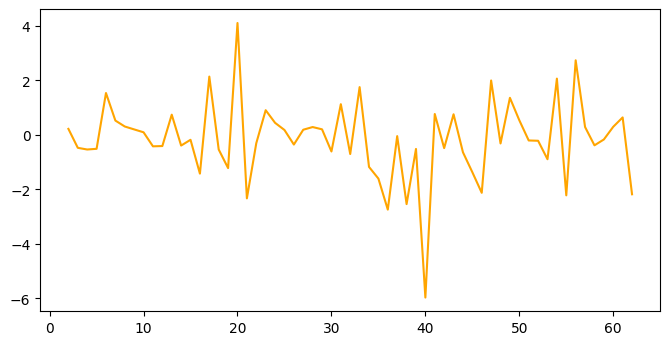

In [26]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["vzo"].pct_change(), color="orange")

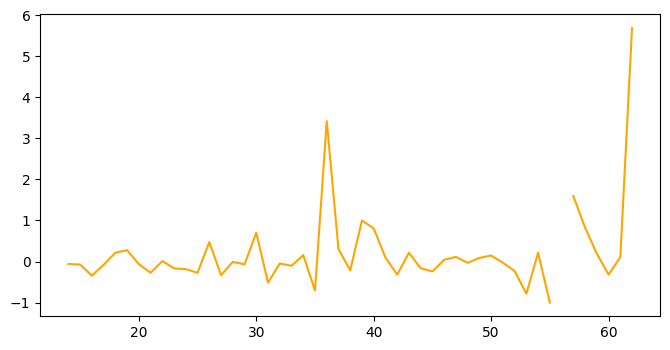

In [27]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["stoch"].pct_change(), color="orange")

In [28]:
vwap = indicators.get_vwap(minute_bars)

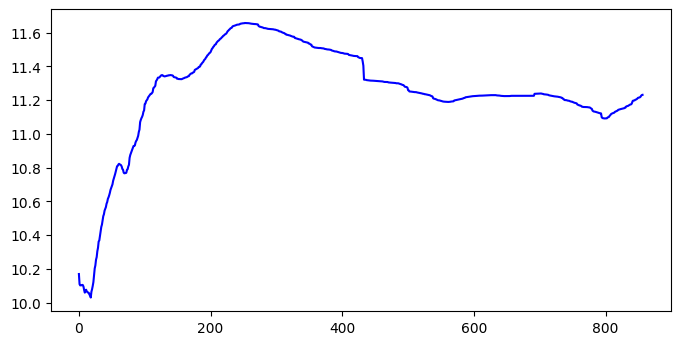

In [29]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(vwap, color="blue")

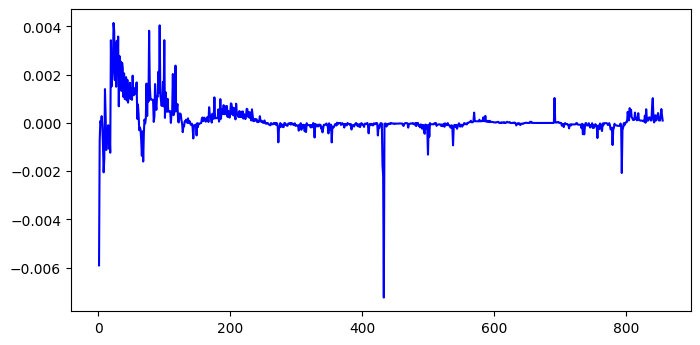

In [30]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(vwap.pct_change(), color="blue")

In [31]:
minute_macd = indicators.get_macd(minute_bars)

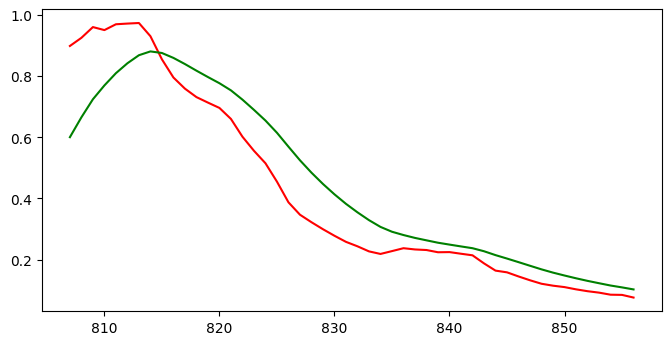

In [32]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(minute_macd["MACD"].iloc[-50:], color="red")
plt.plot(minute_macd["SIGNAL"].iloc[-50:], color="green")

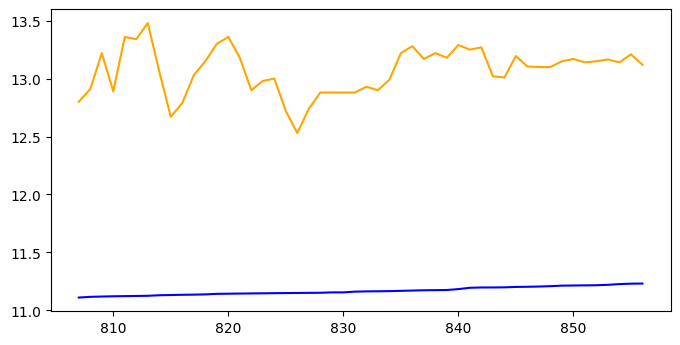

In [33]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(minute_bars["close"].iloc[-50:], color="orange")
plt.plot(vwap.iloc[-50:], color="blue")

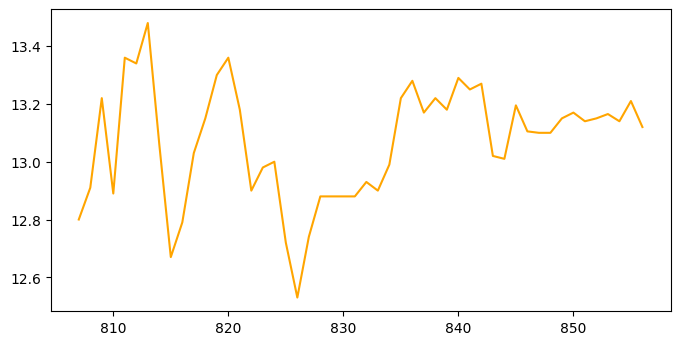

In [34]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(minute_bars["close"].iloc[-50:], color="orange")

In [35]:
# Feature Scaling Normalization
close_prices = pd.DataFrame(minute_bars["close"])
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(close_prices)

In [36]:
# calculate the max drawdown
max_drawdown = max_drawdown(minute_bars["close"])
# day_bars.iloc[-50:]

/home/ben/anaconda3/envs/alpaca_test/lib/python3.7/site-packages/empyrical/stats.py:265: RuntimeWarning:

overflow encountered in multiply

/home/ben/anaconda3/envs/alpaca_test/lib/python3.7/site-packages/empyrical/stats.py:394: RuntimeWarning:

invalid value encountered in subtract



In [37]:
day_spy_bars.iloc[-50:]

,time,open,high,low,close,volume
13,2019-08-27 00:00:00-04:00,289.54,289.9500,286.0300,286.8400,57062542
14,2019-08-28 00:00:00-04:00,286.14,289.0700,285.2500,288.8400,50136080
15,2019-08-29 00:00:00-04:00,291.72,293.1600,290.6100,292.5600,46853904
16,2019-08-30 00:00:00-04:00,294.22,294.2399,291.4200,292.4527,49059839
17,2019-09-03 00:00:00-04:00,290.57,291.5800,289.2700,290.7750,52837823
18,2019-09-04 00:00:00-04:00,293.14,294.0550,292.3100,293.9700,38261914
19,2019-09-05 00:00:00-04:00,296.79,298.8300,294.0010,297.8200,68516970
20,2019-09-06 00:00:00-04:00,298.17,298.7600,297.4200,298.0700,39903355
21,2019-09-09 00:00:00-04:00,299.14,299.2400,297.1600,298.1500,44162496
22,2019-09-10 00:00:00-04:00,297.36,298.2000,295.9700,298.2000,48742185


In [38]:
# calculate alpha and beta
alpha = alpha(minute_bars["close"], minute_spy_bars["close"])
beta = beta(minute_bars["close"], minute_spy_bars["close"])

/home/ben/anaconda3/envs/alpaca_test/lib/python3.7/site-packages/empyrical/stats.py:1294: RuntimeWarning:

overflow encountered in power



In [39]:
print(alpha, beta, max_drawdown)

inf -0.07644226553453871 0.0


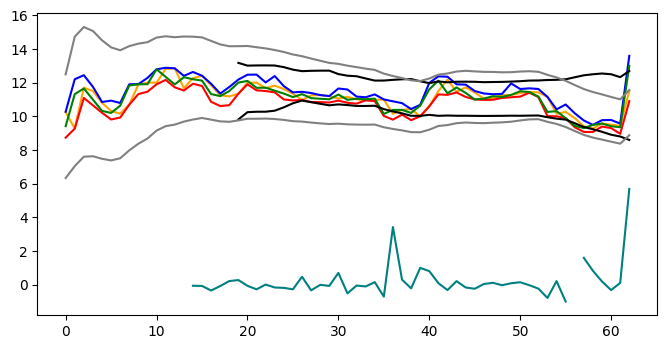

In [40]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["open"], color="orange")
plt.plot(ticker_cluster["high"], color="blue")
plt.plot(ticker_cluster["low"], color="red")
plt.plot(ticker_cluster["close"], color="green")

plt.plot(ticker_cluster["bb_up"], color="black")
plt.plot(ticker_cluster["bb_low"], color="black")
plt.plot(ticker_cluster["apz_u"], color="grey")
plt.plot(ticker_cluster["apz_l"], color="grey")
plt.plot(ticker_cluster["stoch"].pct_change(), color="teal")

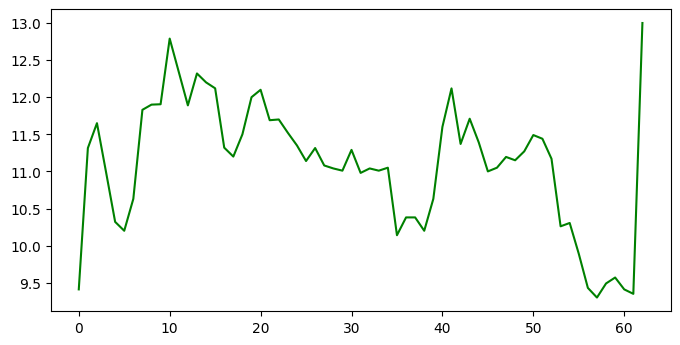

In [41]:
fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(ticker_cluster["close"], color="green")


In [50]:
nd = pd.DataFrame()
nd["close"] = ticker_cluster["close"]
nd["macd"] = ticker_cluster["open"]
nd["signal"] = ticker_cluster["open"]
nd["mfi"] = ticker_cluster["open"]
nd["vzo"] = ticker_cluster["open"]
nd["volume"] = ticker_cluster["open"]
nd["bb_up"] = ticker_cluster["bb_up"]
nd["bb_low"] = ticker_cluster["bb_low"]


heatmap = go.Heatmap(
    z=nd.iloc[-50:].pct_change().corr(method='pearson').values,
    x=nd.columns,
    y=nd.columns,
    colorbar=dict(title='Pearson Coefficient'),
)

layout = go.Layout(title="Pearson correlation of indicators")

heatmap['zmax'] = 1.0
heatmap['zmin'] = -1.0

fig = go.Figure(data=[heatmap], layout=layout)
py.iplot(fig)


In [45]:
ticker_cluster

,time,open,high,low,close,volume,up_move,down_move,DMp,DMm,...,bb_low_ptc,macd_ptc,signal_ptc,vwmacd_ptc,vwsignal_ptc,mfi_ptc,stoch_ptc,vzo_ptc,apz_u_ptc,apz_l_ptc
0,2019-08-08 00:00:00-04:00,10.25,10.2700,8.7307,9.4100,103953,NaN,NaN,0.0000,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-08-09 00:00:00-04:00,9.27,12.2000,9.2700,11.3146,193063,1.9300,-0.5393,1.9300,0.00,...,NaN,inf,inf,inf,inf,NaN,NaN,inf,0.179033,0.112071
2,2019-08-12 00:00:00-04:00,11.70,12.4400,11.0900,11.6500,214976,0.2400,-1.8200,0.2400,0.00,...,NaN,0.517596,0.709702,0.289859,0.541699,NaN,NaN,0.217904,0.039183,0.079576
3,2019-08-13 00:00:00-04:00,11.50,11.7500,10.6500,10.9900,110353,-0.6900,0.4400,0.0000,0.44,...,NaN,-0.236839,0.074302,-0.288572,0.024182,NaN,NaN,-0.477562,-0.015609,0.003509
4,2019-08-14 00:00:00-04:00,10.80,10.8500,10.2100,10.3200,86047,-0.9000,0.4400,0.0000,0.44,...,NaN,-0.728396,-0.205773,-0.795372,-0.233800,NaN,NaN,-0.539145,-0.036628,-0.019794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,2019-10-30 00:00:00-04:00,9.28,9.4900,9.0701,9.4899,80092,-0.2600,-0.0001,0.0000,0.00,...,-0.014232,0.122137,0.314576,0.052488,0.285222,0.067220,0.825652,-0.385758,-0.015178,-0.017977
59,2019-10-31 00:00:00-04:00,9.57,9.7700,9.3900,9.5700,22070,0.2800,-0.3199,0.2800,0.00,...,-0.016330,0.058334,0.214273,0.009543,0.181142,0.181953,0.190760,-0.171302,-0.012371,-0.013523
60,2019-11-01 00:00:00-04:00,9.50,9.7800,9.3000,9.4100,46667,0.0100,0.0900,0.0000,0.09,...,-0.019266,0.061076,0.162007,0.038431,0.135091,0.035273,-0.320000,0.295055,-0.013373,-0.014557
61,2019-11-04 00:00:00-05:00,9.43,9.5681,8.9600,9.3500,160191,-0.2119,0.3400,0.0000,0.34,...,-0.011750,0.044046,0.125258,0.076484,0.117789,-0.322656,0.104859,0.637733,-0.012518,-0.013719
